#### Imports

- Tensorflow used for learning rate scheduling, compiling the learning model, and creates binary labels for data processing
- cv2 used to resize spectrograms
- vit used to define the vision transformer model
- librosa used to load the audio files
- numpy used to normalized the spectrogram data and to generate random numbers
- matplotlib used to display spectrograms
- os used for file paths
- sklearn used to split data into training and test sets
- math used to calculate image dimensions for the vision transformer

In [1]:
import tensorflow_addons as tfa
import cv2
from vit_keras import vit
import librosa
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models 
import os 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
import math

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Path definitions

Potential optimization here is to make it so only the animal folder needs to be used, but these variables store strings that make it easier to access specific filepaths to folders which contain the audio files. This also helps with testing specific aspects of the code. 

In [2]:
animals_folder = '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals'

dog_folder = '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals/dog'
bird_folder = '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals/bird'
other_folder = '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals/other'

dog_single = '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals/dog/dog_1.wav'
bird_single = '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals/bird/Kus_1.wav'
other_single = '/Users/shrutikmk/Documents/Coding/dog-bird-project/animals/other/aslan_1.wav'

# Spectrogram generation and visualization

Neither of these functions are used in the main program-- they are simply used to analyze one specific audio file as a proof of concept. 

## make_spec_data():

### Summary
This function takes in an audio file, loads it using librosa, and then creates a mel-spectrogram returned as a 2D numpy array.
- Arguments: file_name (str): file path to audio file
- Returns: spectrogram (np.array): 2D numpy array of a spectrogram

### Explanation
- librosa.load takes in an audio file, utilizes the default sample rate (via setting sr to None), makes the sound have 1 mono channel, and maximizes resampling quality by using kaiser_best. other types that may be lower quality (but notably faster) are the default soxr_hq, or you can maximize speed by doing soxr_lq. y is the audio data and sr is set to the default sample rate initially. 
- sample rate of the inputted audio file is then obtained by librosa.get_samplerate() and put into sr.
- a spectrogram is generated using the audio data 
- the spectrogram is then converted into a power spectrogram to help visualize contrasts more easily
- the spectrogram is finally returned

In [3]:
def make_spec_data(file_name):
    y, sr = librosa.load(file_name, sr=None, mono=True, res_type='kaiser_best')
    sr = librosa.get_samplerate(file_name)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

## make_spec_picture():

This function takes in a 2D numpy array that contains a spectrogram and uses librosa and matplotlib to show you the spectrogram, plotted. 
- Arguments: spec_data (np.array): 2D numpy array of a spectrogram
- Returns: (nothing), displays the spectrogram

### Explanation
- Creates figure for the plot (10 by 4 inches, this number is arbitrary but it fits the screen size of my mac)
- librosa function used to display the spectrogram via taking in the spectrogram data generated by make_spec_data
- colorbar used to boost quality of life for the graph
- title set to Mel Spectrogram
- plt.tight_layout used to make the graph look prettier via ensuring parameters line up with the display
- plot is then displayed

In [4]:
def make_spec_picture(spec_data):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec_data, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

# Data processing and augmentation 
These functions are used in the main program and build off the previous two functions. 

## make_spectrogram():
Creates spectrogram data given an audio file, which can be augmented if specified. 

Arguments:
- file_name (str): path to the audio file
- augment (bool): whether the audio file should be augmented

Returns: 
- spec_data (numpy.ndarray): spectrogram data

Summary:
- loads an audio file using librosa.load, converted to mono and resampled using kaiser_best
- if augment == True, the audio is augmented using a random method between time_stretch, pitch_shift, or add_noise, each of which have arbitrary probabilities of 0.3/0.3/0.4 respectively
- mel spectrogram is generated via librosa
- the power spectrogram gets converted to decibels so it can be plotted
- the data is then sliced or padded to have a shape of 128x216 so it becomes uniform
- cv2.resize is used to then reshape the data so the vit model can work with it later
- returns spec_data (processed data)

In [5]:
def make_spectrogram(file_name, augment=False):
    y, sr = librosa.load(file_name, sr=None, mono=True, res_type='kaiser_best')
    if augment:
        augment_type = np.random.choice(['time_stretch', 'pitch_shift', 'add_noise'], p=[0.3, 0.3, 0.4])
        y = augment_audio(y, sr, augment_type)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    spec_data = spectrogram[:128, :216]
    if spec_data.shape[1] < 216:
        spec_data = np.pad(spec_data, ((0, 0), (0, 216 - spec_data.shape[1])))
    spec_data = cv2.resize(spec_data, (224, 128))
    return spec_data

## process_files_in_folder():
Processes all of the audio files within a folder, optionally augments them, generates spectrograms from them, and then gives each spectrogram a label. 

Arguments:
- folder_name (str): file path to the folder containing audio files
- label (str): numerical labels to be assigned to each audio file
- augment (bool): whether the audio file should be augmented

Returns:
- data_list (list): list of spectrogram made from the audio files
- label_list (list): list of labels associated with each file

Summary:
- lists all the files in the given folder
- initializes data_list and label_list
- loops over each file in the folder
- if the file is a '.wav' or '.flac' a spectrogram is generated from the audio file, which is augmented prior if specified to be
- spectrogram data gets appended to data_list
- label for the data appended to label_list
- lists are returned

In [6]:
def process_files_in_folder(folder_name, label, augment=False):
    file_list = os.listdir(folder_name)
    data_list = []
    label_list = []
    for file_name in file_list:
        if file_name.endswith('.wav' or '.flac'):
            spec_data = make_spectrogram(os.path.join(folder_name, file_name), augment=augment)
            data_list.append(spec_data)
            label_list.append(label)
    return data_list, label_list

## prepare_data():

Processes the audio files in each folder using process_files_in_folder(), assigns each audio file from each folder to a label, and then converts the generated spectrograms and labels into a NumPy array.

Returns:
- data_array_three (np.ndarray): spectrogram data from the audio files- has three channels to work with the vit model
- label_array (np.ndarray): array of labels associated with each audio file

Summary:
- initializes data_list and label_list to store spectrogram and label data
- loops over files in each folder (hard coded), each of which has a label 
- uses process_files_in_folder() to generate labels and spectrogram data per audio file and append it to their respective list
- lists are then converted to numpy arrays
- data_array is expanded to fit the dimension requirements of the vit model

In [7]:
def prepare_data():
    data_list = []
    label_list = []
    for file, label in [(dog_folder, 0), (bird_folder, 1), (other_folder, 2)]:
        data, labels = process_files_in_folder(file, label, augment=True)
        data_list += data
        label_list += labels
    data_array = np.array(data_list)
    label_array = np.array(label_list)
    data_array_three = np.repeat(data_array[..., np.newaxis], 3, -1)
    return data_array_three, label_array

## augment_audio():

Arguments:
- y (np.ndarray): audio data
- sr (int): sample rate of the audio
- augment_type (str): type of augmentation to be applied

Returns:
- y_augmented (np.ndarray): audio data post-augmentation effects being applied

Summary:
- takes in audio data, sample rate, and augment type

- if selecting time_stretch, a random integer between 0.9 and 1.1 (ensures audio is still recognizable by limiting range) is generated as the factor of which the audio's speed will be changed
- the new length of the audio is then generated by taking the length of the audio data and then dividing it by the integer
- the audio is then stretched or compressed to match this generated length

- for pitch_shift, a random number between -2 and 3 is generated
- the audio pitch is then shifted by the prior number of steps 

- for add noise, a random amount of noise is added to the audio data

- the audio, now augmented by one of the three options, is then returned

In [8]:
def augment_audio(y, sr, augment_type):
    if augment_type == 'time_stretch':
        speed_factor = np.random.uniform(0.9, 1.1)
        
        new_length = int(len(y) / speed_factor)
        y_augmented = np.interp(np.linspace(0, len(y), new_length), np.arange(len(y)), y)
    elif augment_type == 'pitch_shift':
        steps = np.random.randint(-2, 3)
        if steps == 0:
            steps = 1
        y_augmented = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)
    elif augment_type == 'add_noise':
        noise = np.random.randn(len(y))
        y_augmented = y + noise
    else:
        return y
    return y_augmented

# Data preparation

- Data and labels are prepared using prepare_data()
- Data and labels are then split into training and testing batches using train_test_split() from sklearn
- Random state of 42 assigned to ensure these results are reproducible
- Data is then normalized, which helps the vit operate faster
- Labels are one hot encoded, which converts the categorical data into data the model can work with 

In [9]:
data, labels = prepare_data()
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

train_data = (train_data - np.mean(train_data)) / np.std(train_data)
test_data = (test_data - np.mean(test_data)) / np.std(test_data)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=3)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=3)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Note: Illegal Audio-MPEG-Header 0x66616374 at offset 2266.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x66616374 at offset 12730.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x4c495354 at offset 40390.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


# Model setup

## lr_schedule():
Slows the learning rate after the fifth epoch. A slowed learning rate should improve accuracy. 

Arguments:
- epoch (int): the current epoch during training
- lr (float): exisiting learning rate of the model 

Returns:
- lr (float): adjusted learning rate

Summary:
- looks at the epoch number
- if the epoch number is below 5, the learning rate is unchanged
- if it is above 5, the learning rate is set to 10% of its original size

then uses keras LearningRateScheduler class to create a learning schedule that the vit model can work with based on what we defined in the function

In [ ]:
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.01
    
lr_scheduler = LearningRateScheduler(lr_schedule)

## create_vit_model():
creates a vision transformer model for machine learning/audio classification

returns:
- model (tf.keras.Sequential): final vision transformer model 

summary:
- defines patch size (16x16) and the image size that will eventually be divided into said patches (has to be multiple of 16)
- resizes image to ensure they can be divided into the patches evenly

then defines the vit model 
- b32 used as it's relatively faster than the other models while still being large enough to have high accuracy
- softmax activation makes it so the model uses the highest probability to make a decision 
- pretrained being set to true makes it so the model has more data to make decisions based off of
- discarding the top classification layers allows the model to solely use our training data to make a judgement
- 3 classes to line up with the number of classes the data has

defines the ml model using keras
- sequential used to build the model using multiple classification layers
- flatten used to limit output to one dimension
- dense layer used to generate probability to make decision
- softmax ensures the probabilities make sense

model is then returned

In [ ]:
def create_vit_model():
    patch_size = 16
    image_height = 128
    image_width = 216
    
    image_height = int(math.ceil(image_height / patch_size)) * patch_size
    image_width = int(math.ceil(image_width / patch_size)) * patch_size

    vit_model = vit.vit_b32( 
        image_size=(image_height, image_width),
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=3
    )

    model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    return model

### Making the model ready for use

model is created, and then configured for training (specified how the model will learn and what its metrics are)

- adam used because adam is good with handling large datasets
- categorical_crossentropy used due to multi classification problem (dog/bird/other)
- metrics of recall and precision used for accuracy determination 
- recall = true positives / (true positives + false negatives)
- precision = true positives / (true positivies + false positives)

model is then trained on the previously defined data
- saving to a variable allows us to analyze it later
- model.fit() fits the model to the data we aim to train it on and test
- train_data and train_labels is data we aim to train the model on

- epochs are the number of times the dataset will be reviewed by the model 
- something to note: more epochs yields higher accuracy, this notebook just uses 2 for testing purposes but you generally want 20

- validation data of test_data and test_labels gives the model unseen data to base the accuracy metrics on
- callbacks helps define the learning rate
- shuffle being true shuffles the training data, thus allowing for better generalization 

In [ ]:
model = create_vit_model()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 4
  warnings.warn(


In [ ]:
history = model.fit(train_data, train_labels, epochs=2, validation_data=(test_data, test_labels), callbacks = [lr_scheduler], shuffle = True)

Epoch 1/2
469/469 [==============================] - 9007s 19s/step - loss: 0.2253 - recall: 0.9312 - precision: 0.9406 - val_loss: 0.1545 - val_recall: 0.9438 - val_precision: 0.9565 - lr: 0.0010
Epoch 2/2
157/469 [=========>....................] - ETA: 9:56 - loss: 0.1612 - recall: 0.9482 - precision: 0.9557

# Model evaluation
Now that the model is trained, let's feed it the test data to see how well it predicts things. 

In [ ]:
predictions = model.predict(test_data)

118/118 [==============================] - 57s 475ms/step


The model predicts a label when fed a spectrogram. Since the labels are one-hot-encoded, the model will yield probabilities corresponding to each label.
predicted_classes takes a look at these probabilities and narrows down the choices based on what the model yields. argmax ensures it selects the highest probability.
true_classes does the same thing for the true values of the one hot encoded test data labels.

the accuracy metric is then determined by seeing, on average, how often the predicted_classes are equal to the true_classes (how often the prediction is the real thing). 

In [ ]:
predicted_classes = np.argmax(predictions, axis=1) 
true_classes = np.argmax(test_labels, axis=1)  

accuracy = np.mean(predicted_classes == true_classes) 
print("Accuracy:", accuracy)

Accuracy: 0.9541699973354649


We then plot the loss and recall to gain an idea of how the performance of the model is. 

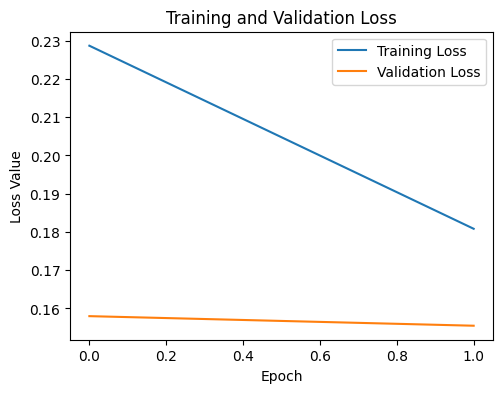

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

plt.show()